## Load fill and beam modes

In [1]:
import pytimber
import datetime
import pagestore
import time, calendar
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Retrieve data from database and start analysis

In [ ]:
ts1=np.load(output_path+'timestamps_ADT/timestamps_array_fill5294_B2H_slot79_PUboth.npy')



In [ ]:
time.localtime(ts1)

In [ ]:
ts2 = ts1[0]+datetime.timedelta

In [122]:
%matplotlib notebook
db=pagestore.PageStore('/home/nbiancac/HDD/Work/MD/LHC/DB/lhc.db','/home/nbiancac/HDD/Work/MD/LHC/DB/')
import LHC_BBQ, LHC_BCT, LHC_Energy, LHC_Coll, LHC_BQM, LHC_BSRT, LHC_FBCT

filln=5294
output_path='/home/nbiancac/HDD/Work/MD/LHC/'+str(filln)+'/'
# os.mkdir(output_path)
beam=2
slot = 79
tag=str(filln)+'_B'+str(beam)+'_slot'+str(slot)


# index=np.load(output_path+'timestamps_ADT/timestamps_array_fill'+str(filln)+'_B'+str(beam)+'H_slot'+str(slot)+'_PUboth.npy')

# ts1=  index[21]+datetime.timedelta(seconds=0)
# ts2 = ts1+datetime.timedelta(seconds=30)


# ts1 = time.mktime(ts1.timetuple())
# ts2 = time.mktime(ts2.timetuple())

# print (ts1)
# print (ts2)

# print 'ts1 = '+time.strftime("%b %d %Y %H:%M:%S", time.localtime(ts1))
# print 'ts2 = '+time.strftime("%b %d %Y %H:%M:%S", time.localtime(ts2))

<IPython.core.display.Javascript object>


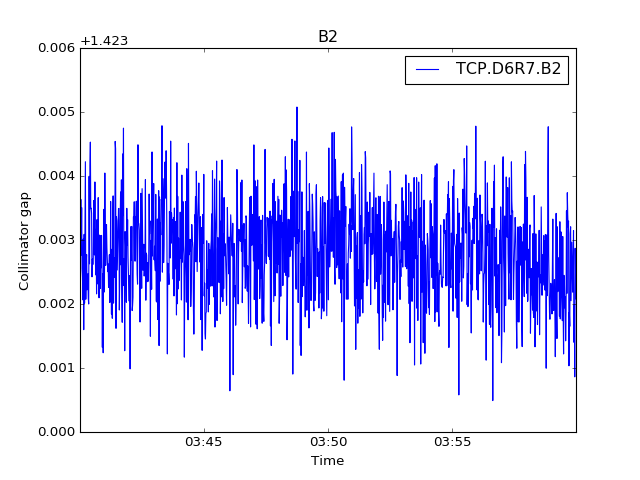

'/home/nbiancac/HDD/Work/MD/LHC/5294/5294_B2_slot79_gap_B2.pdf'

In [123]:
# Collimators
ts1 = calendar.timegm(time.strptime("2016-09-11 03:40:00","%Y-%m-%d %H:%M:%S"))-2*3600
ts2 = calendar.timegm(time.strptime("2016-09-11 04:00:00","%Y-%m-%d %H:%M:%S"))-2*3600

data=db.get(LHC_Coll.variable_list(beam),ts1,ts2)

Coll=LHC_Coll.Coll(data,beam=beam)
typecoll=['L','R']
namecoll = 'TCP.D6'+typecoll[beam-1]+'7.B'+str(beam)
Coll.select_coll(namecoll+':MEAS_LVDT_GU')

plt.figure()
plt.plot(Coll.t_str, Coll.values, "-b")
plt.xlabel("Time")
plt.ylabel("Collimator gap")
plt.title('B%d'%(Coll.beam))
plt.legend([namecoll])
xfmt = mpl.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)

plt.savefig(output_path+tag+'_gap_B'+str(beam)+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_gap_B'+str(beam)+'.png', transparent=True)
output_path+tag+'_gap_B'+str(beam)+'.pdf'

### Sussix

In [139]:
beam

2

In [140]:
index=np.load(output_path+'timestamps_ADT/timestamps_array_fill'+str(filln)+'_B'+str(beam)+'H_slot'+str(slot)+'_PUboth.npy')

In [147]:
import PySussix as ps

# Sussix settings
Nturn=500
nharm = 25

tunex0 = 0.27
tuney0 = 0.295
ex0 = 1e-3
ey0 = 1e-3

tuney_vec=[];tunex_vec=[];
spec_ox=[]; spec_oy=[];
spec_ax=[]; spec_ay=[];
spec_t=[];

for ii in np.arange(0, len(index)):
    
    ts1=  index[ii]+datetime.timedelta(seconds=0)
    ts2 = ts1+datetime.timedelta(seconds=30)


    ts1 = time.mktime(ts1.timetuple())
    ts2 = time.mktime(ts2.timetuple())

    data=db.get(LHC_BBQ.variable_list_RAW(beams=[beam]),ts1,ts2)
    BBQ_RAW=LHC_BBQ.BBQHS_RAW(data,beam=beam)


    cut = int(round(np.diff(BBQ_RAW.t_stamps[0:2])*11245.5))
    BBQ_RAW.v = np.squeeze(BBQ_RAW.v[:,0:cut].reshape(1,-1))
    BBQ_RAW.v = BBQ_RAW.v[BBQ_RAW.v.argmax():BBQ_RAW.v.argmax()+Nturn]

    BBQ_RAW.h = np.squeeze(BBQ_RAW.h[:,0:cut].reshape(1,-1))
    BBQ_RAW.h = BBQ_RAW.h[BBQ_RAW.h.argmax():BBQ_RAW.h.argmax()+Nturn]
    
    datax=BBQ_RAW.h-np.mean(BBQ_RAW.h)
    datay=BBQ_RAW.v-np.mean(BBQ_RAW.v)
    
    spec=ps.Sussix()
    spec.sussix_inp(nt1=1,nt2=Nturn,tunex=tunex0,tuney=tuney0,ex=ex0,ey=ey0,ir=1,nharm=nharm)
    spec.sussix(datax,0*datax, 
                datay, 0*datay, 
                0*datax, 0*datay)
    

    
    spec.ox=np.abs(spec.ox)
    spec.oy=np.abs(spec.oy)
    
    spec_ox.append(spec.ox[0:nharm-1])
    spec_oy.append(spec.oy[0:nharm-1])
    spec_ax.append(spec.ax[0:nharm-1])
    spec_ay.append(spec.ay[0:nharm-1])
    spec_t.append(ts1)
    
    del(datax,datay)

<IPython.core.display.Javascript object>


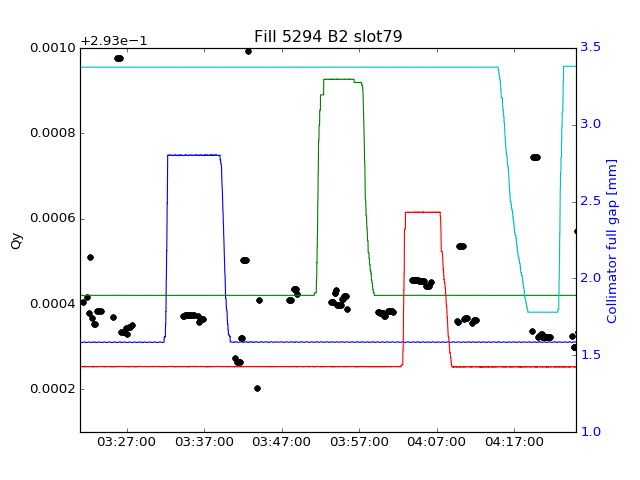

'/home/nbiancac/HDD/Work/MD/LHC/5294/5294_B2_slot79_sussix_B2.pdf'

In [148]:
[tunex_min, tunex_max] = np.sort([0.251 , 0.28])
[tuney_min, tuney_max] = np.sort([0.293 , 0.294])

rangex=np.array([tunex_min, tunex_max])
rangey=np.array([tuney_min, tuney_max])

tuney_vec=[]

for ii,index2 in enumerate((np.abs(spec_oy) < rangey.max()) & (np.abs(spec_oy) > rangey.min())):
    spec.oy = np.squeeze(spec_oy[ii])[index2]
    spec.ay = np.squeeze(spec_ay[ii])[index2]
    
    if len(spec.ay):
        tuney=spec.oy[spec.ay.argmax()]
    else:
        tuney=np.NaN
    tuney_vec.append(tuney)

BBQ_RAW.qv=np.array(tuney_vec)

tunex_vec=[]

for ii,index2 in enumerate((np.abs(spec_ox) < rangex.max()) & (np.abs(spec_ox) > rangex.min())):
    spec.ox = np.squeeze(spec_ox[ii])[index2]
    spec.ax = np.squeeze(spec_ax[ii])[index2]
    
    if len(spec.ax):
        tunex=spec.ox[spec.ax.argmax()]
    else:
        tunex=np.NaN
    tunex_vec.append(tunex)

BBQ_RAW.qh=np.array(tunex_vec)

t_stamp = np.squeeze(np.reshape(np.asarray(spec_t),(1,-1)))
t_str = [datetime.datetime.fromtimestamp(x) for x in t_stamp]

plt.figure()
ax1 = plt.subplot(1,1,1)
plt.plot(t_str,BBQ_RAW.qv,'ok',alpha=1,markerfacecolor='k', markersize=5)
plt.ylabel('Qy')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)
# ax1.set_ylim(0.2930, 0.2936)

ax2 = ax1.twinx()

data=db.get(LHC_Coll.variable_list(beam),min(spec_t),max(spec_t))
Coll=LHC_Coll.Coll(data,beam=beam)
typecoll=['L','R']
namecolls = ['TCP.'+ss+'6'+typecoll[beam-1]+'7.B'+str(beam) for ss in ['B', 'C', 'D']]
namecolls.append('TCP.6'+typecoll[-2:][beam-1]+'3.B'+str(beam))
for namecoll in namecolls:
    Coll.select_coll(namecoll+':MEAS_LVDT_GU')
    ax2.plot(Coll.t_str, Coll.values, '-')
ax2.set_xlabel('time')
ax2.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M:%S')
ax2.xaxis.set_major_formatter(xfmt)
plt.ylim(1,5)

x1 = datetime.datetime.strptime('2016 09 11 03 21 00', '%Y %m %d %H %M %S')
x2 = datetime.datetime.strptime('2016 09 11 04 25 00', '%Y %m %d %H %M %S')
ax2.set_xlim(x1,x2)
ax2.set_ylim(1, 3.5)

plt.title('Fill '+tag.replace('_',' '))

plt.savefig(output_path+tag+'_sussix_B'+str(beam)+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_sussix_B'+str(beam)+'.png', transparent=True)
output_path+tag+'_sussix_B'+str(beam)+'.pdf'


In [128]:
BBQ_RAW.qv

array([        nan,         nan,  0.29311986,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.29394221,         nan,         nan,         nan,         nan,
               nan,  0.29336664,  0.293278  ,  0.29340509,  0.29341534,
        0.29337914,  0.2935098 ,  0.29336748,  0.29335049,  0.29335049,
        0.29338134,  0.29338134,  0.29338134,  0.29336686,         nan,
               nan,         nan,  0.29333148,  0.29333148,  0.29333148,
        0.29334123,  0.29332709,  0.29334581,  0.29334581,  0.29334804,
        0.29336981,  0.29336981,  0.293372  ,  0.293372  ,  0.293372  ,
        0.293372  ,  0.29337292,  0.29337292,  0.29337292,  0.29337292,
        0.29337275,  0.29335643,  0.29336421,  0.29336421,  0.29327272,
        0.29326203,  0.29326203,  0.29326203,  0.29326203,  0.29331918,
        0.29331918,  0.29350304,  0.29350304,  0.29350304,  0.29

In [116]:
x1

NameError: name 'x1' is not defined